In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib
import matplotlib.pyplot as plt
import mne
from utils.loader import load_data, unicorn_fs, unicorn_channels, convert_to_mne, unicorn_eeg_channels
%matplotlib inline
#matplotlib.use("Qt5Agg")

In [7]:
# PATH
recording_type = ['resting', 'listening', 'playing']
path_data = 'data/recordings/' + recording_type[2]
files = [f for f in os.listdir(path_data) if f.endswith('.csv')]
path_file = os.path.join(path_data, files[0])

In [8]:
# NOTE: skiprows=5 is needed to skip the first 5 rows of the csv file
eeg, trigger, dataframe = load_data(path_file, header=False, fs=unicorn_fs, skiprows=5)
dataframe

,Fz,C3,Cz,C4,Pz,PO7,Oz,PO8,acc_x,acc_y,acc_z,STI
0,8.126,11.912,-1.518,9.514,-38.411,16.706,10.160,2.808,-0.066,1.035,0.016,0.0
1,15.930,33.869,2.379,15.674,8.586,39.731,25.967,6.069,-0.070,1.033,0.016,0.0
2,24.253,55.929,5.554,22.177,55.268,61.247,41.151,10.187,-0.074,1.031,0.021,0.0
3,30.503,67.089,7.116,27.604,87.022,74.287,52.055,15.515,-0.078,1.027,0.024,0.0
4,24.928,59.209,4.926,23.675,94.289,71.424,50.026,13.638,-0.080,1.023,0.021,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
5136,-4.883,4.085,-1.165,-2.823,8.202,16.973,1.661,2.472,-0.072,1.004,-0.015,0.0
5137,-12.517,-5.586,-10.220,-10.564,0.250,7.124,-5.514,-4.179,-0.072,1.003,-0.016,0.0
5138,-17.637,-12.429,-20.021,-16.356,-7.905,-1.364,-11.587,-8.485,-0.074,1.006,-0.015,0.0
5139,-14.596,-8.604,-19.817,-15.001,-4.080,0.693,-9.715,-5.323,-0.077,1.008,-0.014,0.0


#### Convert to MNE format
MNE is a popular Python library for EEG data analysis. It provides a simple and intuitive way to work with EEG data, and it is widely used in the scientific community. The library provides many useful tools for EEG data analysis, such as data visualization, signal processing, and machine learning. In this section, we will convert the EEG data to the MNE format, so that we can use the library to analyze the data.
Documentation: [MNE](https://mne.tools/stable/index.html)

In [9]:
# Convert to MNE format
raw_data = convert_to_mne(eeg, trigger, fs=unicorn_fs, chs=unicorn_eeg_channels, recompute=False) # recompute=True to recalculate the event labels if the values are negative

Creating RawArray with float64 data, n_channels=8, n_times=5141
    Range : 0 ... 5140 =      0.000 ...    20.560 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=5141
    Range : 0 ... 5140 =      0.000 ...    20.560 secs
Ready.


Effective window size : 8.192 (s)


C:\Users\Gianni\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\mne\viz\utils.py:165: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


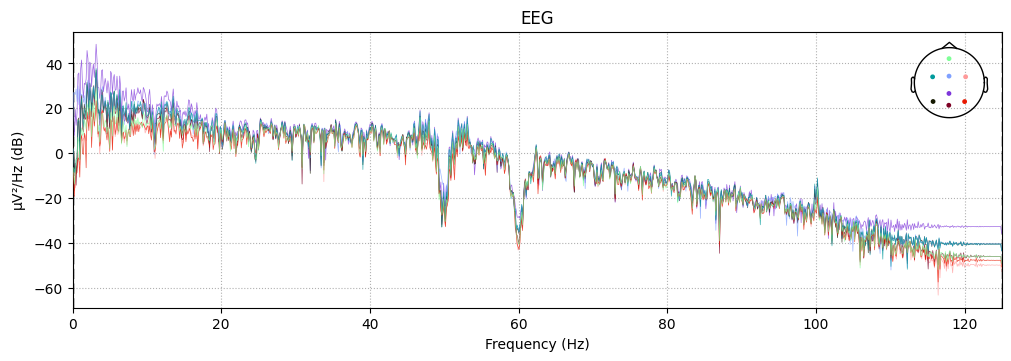

In [10]:
# Compute PSD
Pxx = raw_data.compute_psd(fmin=0, fmax=unicorn_fs/2)
Pxx.plot()
plt.show()

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 1651 samples (6.604 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband e

C:\Users\Gianni\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\mne\viz\utils.py:165: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


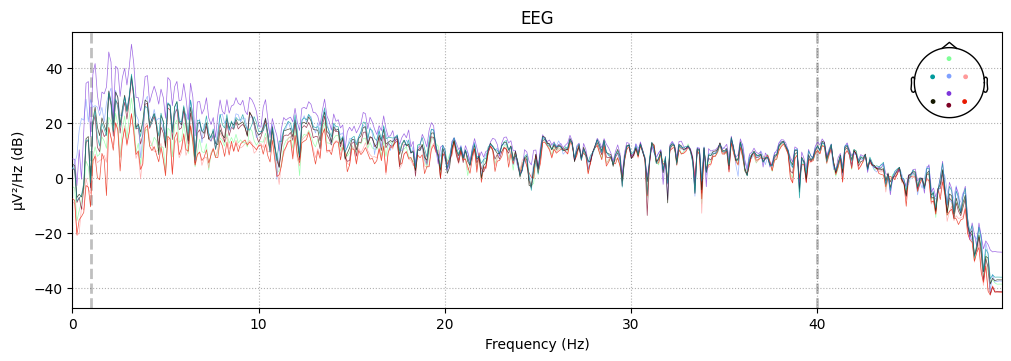

In [11]:
filtered = raw_data.copy() # the method filters the signal in-place, so this time I
                      # want to preserve the original signal and filter just a
                      # temporary copy of it

# remove power line noise
filtered.notch_filter(50) 
filtered.notch_filter(60) 
# Apply band-pass filtering
filtered.filter(1,40) 

pxx_filt = filtered.compute_psd(fmin=0, fmax=50)
pxx_filt.plot()
plt.show()

### Data Analysis


1. Mark the events with custom labels 
2. Epoching and baseline correction
3. Extract EEG data from epoch and define baseline segment.
4. Compute average P300 across epochs and channels.
5. Visualize ERPs for each channel.
6. Compute time-frequency representation using Morlet wavelets.
7. Compute power spectral density (PSD) and plot topographic map.

#### 1. Mark the events with custom labels
To extract events we need to provide the raw data and the name of the channel that contains the trigger information. The function `find_events()` will return a numpy array with the events and the event ids. We can also assign colors to the events to visualize them in the plot.

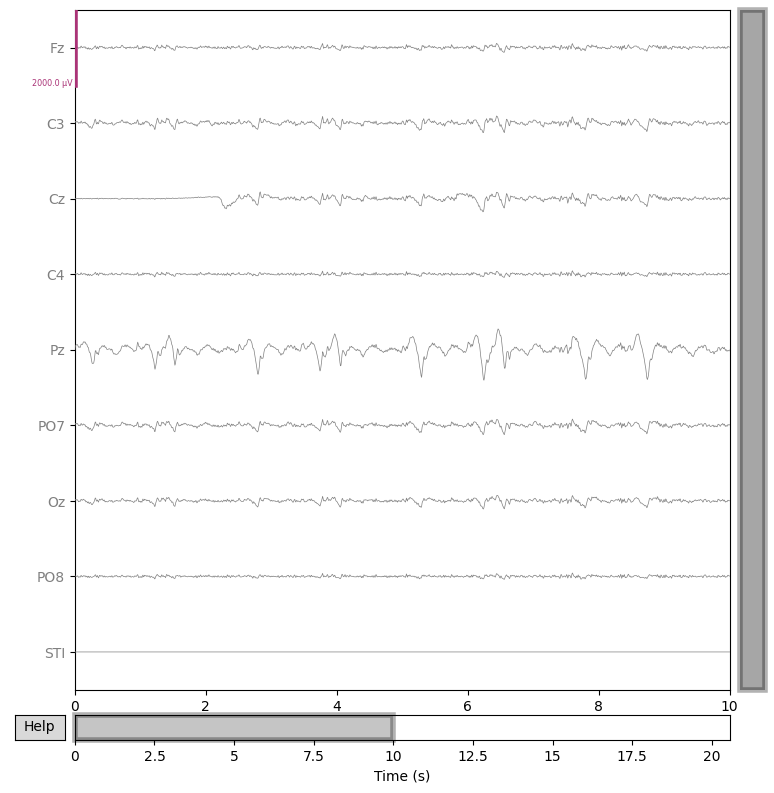

In [15]:
from mne import find_events

ev_ids = {'NT': 2, 'T':1}
event_colors = {2:'r', 1:'g'}
stim_channel = 'STI'
events = find_events(filtered, stim_channel=stim_channel)
filtered.plot(events=events, event_id=ev_ids, event_color=event_colors, color = 'Gray', block = True, clipping=None, scalings=1e-3)
plt.show()